# 04.Regression

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

The goal of this chapter is to take a tour of some most used regression algorithms, show how their parameters are tuned, and build up an understanding of how they differ from one another. 

We will journey through:
* linear regression (with gradient descent) 
* polynomial regressoin (with bayesian approach)
* regression trees
* isotonic regression
* piecewise regression
* logit and softmax
* the big picture

## Overview

When we look at our data, our minds start to seek out patterns. Even before we apply all our statistics knowledge, our minds look for shapes and repeating figures. Augmenting our senses with mathematical analysis and inference tools such that we can observe even more patterns in the world around, is one of the many joys of data science.

## Linear regression

At this point you have come across linear regression as the "line of best fit" in 2D data (the line that optimally minimizes the sum of squared differences between every datapoint and the line). There are two ways we can write the prediction function these process yields:

1. $\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} ...+ \theta_{n}x_{n}$

2. $\hat{y} = \theta^T\cdot(\mathbf{x})$

As we see in the first equation, there is an initial bias term $\theta_{0}$, which serves as the intercept of our function, and then a series of weighted paramters multipled by each of our input features. Each input is weighted in such a way to yield the best approximation of the target value.   

The second equation is just another way to say the ame thing, only in this case the parameters have been aggregated and transposed into a column of values, the matrix $\theta^T$. The x's too have been bundled up into their own matrix $\mathbf{x}$. The little dot between them is a dot product, which, when performed on these matrices, yields what we see in the first equation. For a review of linear algegra notation, check out: https://github.com/ageron/handson-ml/blob/master/math_linear_algebra.ipynb

Our aim is to find the correct weights for each feature that will yield the most accurate target output. To find these ideal parameter weights, we need a cost function (a measure of how successful we are in creating predictions), and for linear regression we commonly use **Mean Square Error (MSE)**:

$MSE(\theta) = \frac{1}{m}\sum_{i=1}^m(\theta^T\cdot\mathbf{x}^i - y^i)^2$

The part after the $\sum$ should look familiar - it's the difference between our predicted $\hat{y}$ value ($\theta^T\cdot\mathbf{x}^i$) and the actual $y$ value for each $i$ instance. Square the differences, sum them up across all $m$ instances, and divide by the number $m$, and you've got your MSE. 

We can compute the paramter values that minimize the MSE directly by using the normal equation. For our purposes, we'll stick with a general overview of how this works, but please check out the following article if you're looking for more details: http://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression

Let's pick up the normal function derivation story right before the end:

$\mathbf{X}^T\cdot\theta = \mathbf{X}^T\cdot\mathbf{y}$

At this point in the derivation the equation makes intuitive sense if we remember what we're ultimately seeking to do (estimate the ideal parameters to equal what would be observed with the true labels). By take the dot product of the transposed matrix of inputs ($\mathbf{X}^T$) and the vector of labels ($\mathbf{y}$), we arrive at the output we are trying to estimate with our dot product of the X transposed matrix and the parameter theta. All we have do know is solve for $\theta$ by multiplying both sides by $\mathbf{X}^T\cdot\mathbf{X})^-1$

$\hat{\theta} = (\mathbf{X}^T\cdot\mathbf{X})^-1\cdot\mathbf{X}^T\cdot\mathbf{y}$

Using the normal equation to calculate $\theta$ can be useful with small feature sets, but we'll now look at an algorithm that is more commonly used in machine learning projects. 

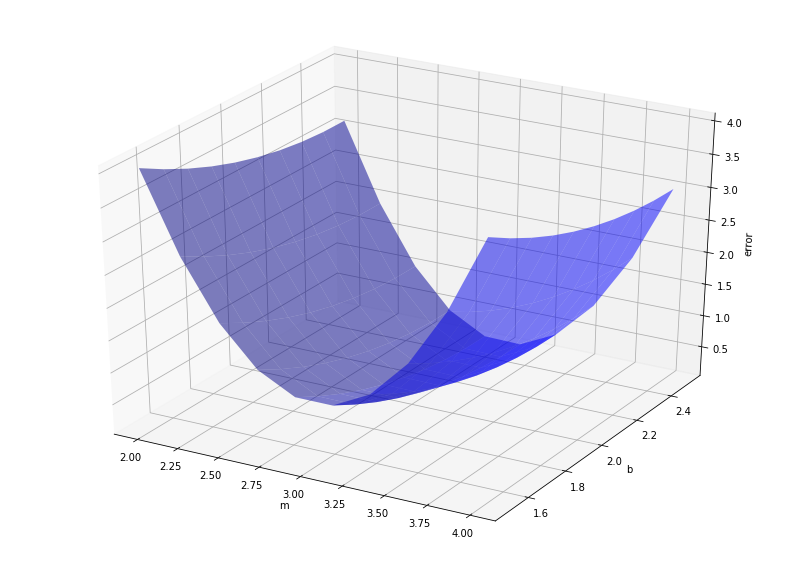

In [17]:
#https://stackoverflow.com/questions/28542686/3d-plot-of-the-error-function-in-a-linear-regression

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections

def error(m, b, points):
    totalError = 0
    for i in range(0, len(points)):
        totalError += (points[i].y - (m * points[i].x + b)) ** 2
    return totalError / float(len(points))

x = y = np.arange(-3.0, 3.0, 0.05)
Point = collections.namedtuple('Point', ['x', 'y'])

m, b = 3, 2
noise = np.random.random(x.size)
points = [Point(xp, m*xp+b+err) for xp,err in zip(x, noise)]

fig = plt.figure(figsize = (14, 10))
ax = fig.add_subplot(111, projection='3d')

ms = np.linspace(2.0, 4.0, 10)
bs = np.linspace(1.5, 2.5, 10)

M, B = np.meshgrid(ms, bs)
zs = np.array([error(mp, bp, points) 
               for mp, bp in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.5)

ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('error')

plt.show()

### Gradient Descent

Gradient descent is an optimization algorithm that minimizes the cost function by making iterative adjustments to parameters. There are three common flavors:
* BATCH - partial parameter derivatives are calculated across ALL instances and grouped into a gradient vector, which indicates where to take the next step
* STOCHASTIC - the gradient vector is calculated using the partial derivative of ONE random instance in the dataset
* MINI-BATCH - like stochastic, only with batches of random instances instead of just one

We first must calculate the **gradient** of the cost function for each parameter $\theta$. 

From Wikipedia:

>Like the derivative, the gradient represents the slope of the tangent of the graph of the function. More precisely, the gradient points in the direction of the greatest rate of increase of the function, and its magnitude is the slope of the graph in that direction.

$\nabla_{\theta} = \frac{2}{m}\mathbf{X}^T\cdot(\mathbf{X}\cdot\theta-\mathbf{y})$

Since the gradient points in the direction of the greatest increase, our function will step in the opposite direction until it finds the global minima of the convex equation. The convext part is worth underscoring. If this wasn't a convex equation, we wouldn't be sure if our gradient stepping was leading us to a local minima or a global minima, so thank goodness MSE cost functions for linear models are convex!

$\theta^{(next step)} = \theta - n\nabla_{\theta}MSE(\theta)$

The $n$ (learning rate) determines the size of the downhill step, and in general we don't want to step to large (might keep stepping over the minima) or too small (might take forever to converge). Converengence is the name of the game. We want to get to the lowest point of the convex function as fast as possible. You can find the learning rate by using grid search. 

You also have to decide how many times you want to iterate over this stepping process, and to help with this you can set a tolerance level, $\epsilon$, that will stop the iteration once the values you're getting back fall below that level. 

### Regularizations (ridge, lasso, elastic net)

There are three regularized versions of linear regression that I want to mention in passing, as they will come in handy when trying to reduce overfitting of your data. Basically, if you normalize the data in some way before optimizing your cost function, you can increase your liklihood of building a model that is more useful in novel situations. There are three tools often used to bound the weights so they can only get so large or small. 

* **Ridge Regression** adds a regulization term to $MSE(\theta)$ in the cost function: $\alpha\frac{1}{2}\sum^n_{i=1}\theta^2_{i}$

* **Lasso Regression** adds a different regularization term $MSE(\theta)$ in the cost function: $\alpha\sum^n_{i=1}\lvert\theta_{i}\rvert$

* **Elastic Net** applies whatever is the min of Ridge or Lasso

## Polynomial regression

While it can be prone to overfitting, I'm fond of polynomial regression in situations where the data is curvilinearly distributed. The equation for the line of best fit will look a lot like our linear regression (with an intercept and coefficients for each inputer parmater), yet for polynomial regression there will be at least one variable with a power greater than 1. 

To account for the overfitting possibility, you may want to code up a learning curve, which gets into a broader conversation of bias and variance (which I've lumped into the chapter on optimization). 

### Bayesian approach

Polynomial regressions are useful at capturing more details of the variance, and really come alive when they take on a Bayesian flavor (assessing the percentage of variance captured as we move through the function). 

## Regression trees

Regression Trees (or, more specifically, the Classification and Regression Tree (CART) algorithm) work the same way as their classficition counterparts (Decision Trees), only when you get down to the terminal node (leaf) in your search, your delivered a value instead of a classification. The general premise is that you are presented with input data, and make your way through a binary search algorithm until you can't take any more steps.  

To train, or "grow", a regression tree, you must choose an algorithm to determine the optimal architecture. This is typically accomplished by using one of two impurity measures (which in general yield similiar trees):  

* **Gini**
A node's Gini score measures class "purity", which is to say homogeneity of classification of the training set. If all the instances are from the same class, the node is "pure". It's measured by suming the squared rations of class instances in the training set and subtracting that sum from 1. 

> $G_{i} = 1 - \sum^n_{k = 1}p_{i,k}^2$

* **Entropy**
A node's entropy is zero when all its members are of the same class.

> $H_{i} = - \sum^n_{k = 1}p_{i,k}log(p_{i,k})$



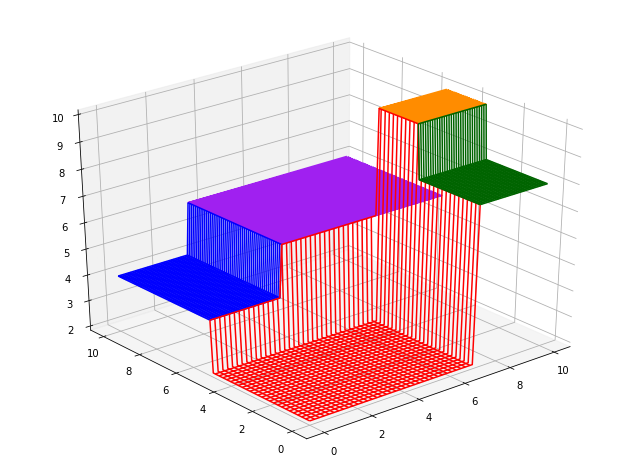

In [6]:
# Here's a super cute graphic for regression trees from Kevin Murphy's book

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import os

t1 = 5
t3 = 3
t2 = 7
t4 = 3

r = np.linspace(2, 10, 5)

#A function to return a tree for given (x1,x2) coordinates
def ManualTree(x1, x2):
    if x1 <= t1:
        if x2 <= t2:
            z = r[0]
        else:
            if x1 <= t3:
                z = r[3]
            else:
                z = r[4]
    else:
        if x2 <= t4:
            z = r[1]
        else:
            z = r[2]
    return(z)

ManualTree = np.vectorize(ManualTree)

x = np.linspace(0,10,100)
X, Y = np.meshgrid(x, x)
Z = ManualTree(X.T,Y.T)

#A 3D matrix for determining which colors go where.

def DivList(list1, den):
    return([e/den for e in list1])

#This tells us which color we use for which output tree value. Intended to match with the latex tree graphic.
def ColorMapper(z):
    if z == r[0]:
        out = DivList([255.0, 0.0, 0.0], 255.0)
    elif z == r[1]:
        out = DivList([0.0, 0.0, 255.0], 255.0)
    elif z == r[2]:
        out = DivList([160.0, 32.0, 240.0], 255.0)
    elif z == r[3]:
        out = DivList([0.0, 100.0, 0.0], 255.0)
    else:
        out = DivList([255.0, 140.0, 0.0], 255.0)
    return(out)

#Manually build the tree, one output tree value at a top. 
#For some spots, we need to add in the walls to show difference between two tree values.
fig = plt.figure(figsize=(20.0/1.8, 15.0/1.8))
ax = fig.add_subplot(111, projection='3d')
for val in r:   
    if val in [2, 4, 8]:
        logi = Z == val
        if val == 2:
            logi[50,0:70] = True
            logi[:51,70] = True
            shp = (51, 71)
        elif val == 4:
            logi[50:,30] = True
            shp = (50, 31)
        else:
            logi[30,70:] = True
            shp = (31, 30)
        x = X[logi].reshape(shp)
        y = Y[logi].reshape(shp)
        z = Z[logi].reshape(shp)
    else:
        x = X[Z==val]
        y = Y[Z==val]
        z = val
    ax.plot_wireframe(x, y, z, color=ColorMapper(val))
        
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(elev=30, azim=230)
plt.show()

## Isotonic Regression

I include isotonic regression (also knows as monotonic regression) in our discussion, because I think it represents an interesting alteranative to the other methods we've seen. Essentially this algorithm draws a line of best fit for data that has to satisfy two conditions: be non-decreasing at all points and lie as close to the points as possible. Imagine drawing a line of best fit on a plot of points where you must keep your pen on the paper at all times, and always be moving up and to the right. That's what an isotonic regression is doing, and it comes in handy when your data is distributed in what looks to be linear globally, bus it actually more tiered when you zoom in on the segments. 


## Piecewise Regression

I'm a fan of this regression because of one of it's nicknames, "broken stick", but also because I find a lot of applications in time-based events in the real world. They crop up everywhere. Something behaves one way for a period of time, then shifts for a period, then shifts back. Like traffic in response to accidents or user behavior in dynamic pricing markets. 

## Logit & Softmax

Logistic regression (logit) relies on a sigmoid function to make a binary classification. It it's classic form, it returns a simple "yes" or "no", but it also has other flavors, such as mulitnomial logistic regression (multiple class outputs) or multiple logistic regression (multiple parameter inputs). 

It's worth noting that in the case of the multinomial logistic regression, a softmax function is used to determine the class. We'll see this again in reinforcement learning, so let's spend a little time with this function.

SOFTMAX FUNCTION:

$\hat{p_{k}} = \sigma(s(\mathbf{x}))_{k} = \frac{\mathrm{e}^{s_{k}(\mathbf{x})}}{\sum^K_{j=1}\mathrm{e}^{s_{j}(\mathbf{x})}}$

To explain this function down, I'm going to quote Aurélian Géron's book directly, because I think his explanation sums it up:

* $K$ is the number of classes.
* $s(\mathbf{x})$ is a vector containing the scores of each class for the instance $\mathbf{x}$.
* $\sigma(s(\mathbf{x}))_{k}$ is the estimated probability that the instance $\mathbf{x}$ belongs so class $k$ given the scores of each class for that instnace.

NOTE: While the convention is typically to set exponents in equations as $\mathrm{exp}^{value}$, I like to use $\mathrm{e}$ to drive home the point that when we put variables as exponents, we are typically using the variable to define the shape of resulting space. For me at least using the $\mathrm{e}$ helps reiterate that, by invoking all the other geometric contexts we have encountered this context.

## Summary

At the end of the day, we define an error function (or well our trained model predicts novel data), and pursue an option that minimizes the error function. I find it helpful to begin with a simple, naive model where every input is equally weighted to predict your output. Sometimes this will work, but mostly it will not. You may intuitively reach for weights, trying to boost up certain predictors more than others, and that's what we see in our regression model, with weighting parameters that can even take in polynomial relationships. 

Our adoption of a logit or softmax function represents a desire to highlight the probability of each classification by boosting the contrast through the sigmoid function. The important concepts here are the relationship between the max-likelihood (which sets our target probability), cross entropy (which give us a numeric value that relates to how likely our model is accurately labeling - with low values being good, and high values being bad), and our error function, which ultimately seeks to minimize the cross-entropy. 